In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00


In [5]:
from huggingface_hub import whoami
print(whoami())


{'type': 'user', 'id': '664eb2c16beee47c797f15c0', 'name': 'deep0210', 'fullname': 'Deep Dey', 'email': 'deepdey715@gmail.com', 'emailVerified': True, 'canPay': False, 'periodEnd': 1743465599, 'isPro': False, 'avatarUrl': '/avatars/f3852de8a9c2b2830bb0166ef9451b8e.svg', 'orgs': [], 'auth': {'type': 'access_token', 'accessToken': {'displayName': 'minor-project-final-project', 'role': 'write', 'createdAt': '2025-03-15T16:44:37.797Z'}}}


In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Model repo name
model_name = "deep0210/hybrid-finetuned-rag-mistral-llm"
token = os.getenv("HF_TOKEN")  # Fetch token from environment

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)

# Load model with automatic device mapping
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    offload_folder="./offload",  # Helps manage memory efficiently
    token=token
).eval()  # Set to evaluation mode


tokenizer_config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.51M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/27.3M [00:00<?, ?B/s]

In [8]:
from datasets import load_dataset

dataset = load_dataset("tatsu-lab/alpaca")
eval_data = dataset["train"].select(range(4000, 4100))


README.md:   0%|          | 0.00/7.47k [00:00<?, ?B/s]

(…)-00000-of-00001-a09b74b3ef9c3b56.parquet:   0%|          | 0.00/24.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

In [9]:
import torch

def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=256)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

eval_results = []
for sample in eval_data:
    prompt = sample["instruction"] + " " + sample["input"]
    ground_truth = sample["output"]
    generated_output = generate_response(prompt)
    
    eval_results.append({
        "prompt": prompt,
        "ground_truth": ground_truth,
        "generated_output": generated_output
    })


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

In [11]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=4ae66bccebd5141b94d03319a290d79f7f99f8658e392f1e2453dcb9c384e662
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [12]:
from evaluate import load
from rouge_score import rouge_scorer
import numpy as np

# Load evaluation metrics
bleu = load("bleu")
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Compute scores
bleu_scores = []
rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

for result in eval_results:
    prediction = result["generated_output"]
    reference = result["ground_truth"]
    
    # BLEU Score
    bleu_score = bleu.compute(predictions=[prediction], references=[[reference]])["bleu"]
    bleu_scores.append(bleu_score)
    
    # ROUGE Scores
    rouge_scores = rouge.score(prediction, reference)
    rouge1_scores.append(rouge_scores["rouge1"].fmeasure)
    rouge2_scores.append(rouge_scores["rouge2"].fmeasure)
    rougeL_scores.append(rouge_scores["rougeL"].fmeasure)

# Compute Averages
avg_bleu = np.mean(bleu_scores)
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

print(f"Average BLEU: {avg_bleu:.4f}")
print(f"Average ROUGE-1: {avg_rouge1:.4f}")
print(f"Average ROUGE-2: {avg_rouge2:.4f}")
print(f"Average ROUGE-L: {avg_rougeL:.4f}")


Average BLEU: 0.0405
Average ROUGE-1: 0.1987
Average ROUGE-2: 0.0843
Average ROUGE-L: 0.1529


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


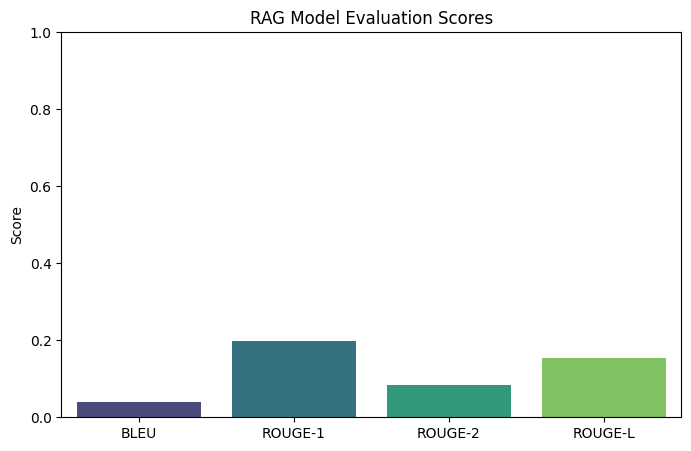

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
metrics = ["BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L"]
scores = [avg_bleu, avg_rouge1, avg_rouge2, avg_rougeL]

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=metrics, y=scores, palette="viridis")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("RAG Model Evaluation Scores")
plt.show()


In [15]:
import torch

def generate_response(prompt, max_length=200):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=max_length, do_sample=True)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Example prompt
prompt = "Explain the concept of reinforcement learning in simple terms."
response = generate_response(prompt)
print("Model Response:", response)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Model Response: Explain the concept of reinforcement learning in simple terms. How does it work? What are the strengths and weaknesses of reinforcement learning?
1.1Explain the concept of reinforcement learning in simple terms. How does it work?
Reinforcement learning is a method of learning in which an agent learns behaviors by getting rewarded for certain actions. The agent receives a reward (positive feedback) or punishment (negative feedback) for each action, and then uses that information to modify its future behavior. The agent then takes the next action, and receives another reward or punishment, and so on. The agent learns which actions lead to the best possible outcome by using this feedback. The goal is for the agent to eventually learn which actions lead to the best possible outcome and which lead to the worst possible outcome.
The concept of reinforcement learning can be explained through the use of a simple game. Let’s say that you are playing a game in which you must move